In [1]:
import json
import requests
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
from geopy.distance import great_circle
from geopy.exc import GeocoderTimedOut
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import seaborn as sns
import pystan
%matplotlib inline
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')


In [2]:
filename = "https://moto.data.socrata.com/resource/4h35-4mtu.json?$$app_token=SGf4MCedoqeOfxb7GPiMDUdf7"
response = requests.get(filename)
data = response.json()
#Data is represented in the form of Data frame 
df = pd.DataFrame(data)

#checking for null values
print(df.isnull().values.all())
print(df.isnull().sum())
#checking for data types
print(df.dtypes)
#converting data types 
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
#looking for erroneous data
tempdf_1 = df[df['created_at'] < df['incident_datetime']] 

tempdf_2 = df[df['updated_at'] < df['created_at']]

#cleaning erroneous data:
parsed_df = df[df['created_at'] >= df['incident_datetime']]



False
address_1                0
case_number              0
city                     0
clearance_type           0
created_at               0
day_of_week              0
hour_of_day              0
incident_datetime        0
incident_description     0
incident_id              0
incident_type_primary    0
latitude                 0
location                 0
longitude                0
parent_incident_type     0
state                    0
updated_at               0
zip                      7
dtype: int64
address_1                object
case_number              object
city                     object
clearance_type           object
created_at               object
day_of_week              object
hour_of_day              object
incident_datetime        object
incident_description     object
incident_id              object
incident_type_primary    object
latitude                 object
location                 object
longitude                object
parent_incident_type     object
state          

In [3]:
# Finding the latitude and longitude of given Starbucks retail store addresses
location_list = {}
locator = Nominatim()
my_address = ['1912 Pike Place Seattle, WA 98101','4634 26th Avenue NE Seattle, WA 98105',
            '10002 Aurora Avenue North Seattle, WA 98133','3300 W. McGraw St. Seattle, WA 98119',
            '1125 4th Avenue Seattle, WA 98101']
for i in my_address:
    try:
        location_list[i] = (locator.geocode(i).latitude,locator.geocode(i).longitude)
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(i, e.msg))




In [5]:
store1 = '1912 Pike Place Seattle, WA 98101'
store2 = '4634 26th Avenue NE Seattle, WA 98105'
store3 = '10002 Aurora Avenue North Seattle, WA 98133' 
store4 = '3300 W. McGraw St. Seattle, WA 98119'
store5 = '1125 4th Avenue Seattle, WA 98101'

In [6]:
#get crimes by tier
def getcrimesby_tier(store,crime_type):
    tier = []
    dictionary = {}
    for i,r in parsed_df.iterrows():
        coordinates  = (r.latitude,r.longitude)
        distance = great_circle(location_list[store],coordinates).miles
        days = (r.incident_datetime.now().date() - r.incident_datetime.date()).days
        if (distance < 20 and days < 150):
            if(r.parent_incident_type in crime_type):
                if (r.incident_datetime.date()) not in dictionary:
                    dictionary[r.incident_datetime.date()] = 1
                else:
                    dictionary[r.incident_datetime.date()] = dictionary[r.incident_datetime.date()] + 1
                    
    for key ,value in dictionary.items():
        tier.append([key,value])

    return tier
    
#creating Data frames 
def create_dataframe(data):
    return pd.DataFrame(data,columns = ['Date','Incidents'])
   
# create forecasting model
def forecast_model(df):
    #Preparing data for Prophet 
    df1 = df.reset_index()
    #for prophet to work, columns should be in teh format ds and y
    df1 = df1.rename(columns={'Date':'ds', 'Incidents':'y'})
    #drawing a plot with ds and y
    df1.set_index('ds').y.plot()
    #converting normal values to log values using numpy's log function to remove anamolies
    df1['y'] = np.log(df1['y'])
    df1.set_index('ds').y.plot()
    #Running Prophet
    model = Prophet(yearly_seasonality =True,weekly_seasonality= True,daily_seasonality = True)
    model.fit(df1);
    #i want to forecast 6 months of data, so am using periods = 6 and "m" means month
    future = model.make_future_dataframe(periods= 6, freq = "m")
    #to forecast this future data we have to run it through prophet model   
    forecast = model.predict(future)
    # we are interested only in yhat, yhat_lower, yhat_upper values
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    #this function plot gives actual data in black dots and forecast data in blue lines
    model.plot(forecast);
        
    #Visualizing prophet models
    df1.set_index('ds', inplace=True)
    forecast.set_index('ds', inplace=True)
    viz_df = df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])
    viz_df[['Incidents', 'yhat_rescaled']].plot()
    #make index as datetime object
    df.index = pd.to_datetime(df.Date) 
    #selecting 2nd from last date
    connect_date = df.index[-2] 
    mask = (forecast.index > connect_date)
    predict_df = forecast.loc[mask]
    viz_df = df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    viz_df['yhat_scaled']=np.exp(viz_df['yhat'])
    #final visualization with actual values and forecast values 
    fig, ax1 = plt.subplots()
    ax1.plot(viz_df.Incidents)
    ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
    ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
    ax1.set_title('Incidents (Orange) vs Incidents Forecast (Black)')
    ax1.set_ylabel('Incidents')
    ax1.set_xlabel('Date')

    L=ax1.legend() #get the legend
    L.get_texts()[0].set_text('Actual Incidents') 
    L.get_texts()[1].set_text('Forecasted Incidents') 
    

In [7]:
def main(store):
    #the three types of crimes 
    Quality = ['Drugs','Liquor']
    Property = ['Property Crime','Theft','Theft of Vehicle','Theft from Vehicle']
    Violent = ['Assualt','Robbery','Breaking & Entering']
    
    #creating three tiers
    tier1 = getcrimesby_tier(store,Quality)
    tier2 = getcrimesby_tier(store,Property)
    tier3 = getcrimesby_tier(store,Violent)
    
    #passing values to create dataframe
    store_tier1df = create_dataframe(tier1) 
    store_tier2df = create_dataframe(tier2) 
    store_tier3df = create_dataframe(tier3) 
    
    #passing values to forecast model
    forecast_model(store_tier1df)
    forecast_model(store_tier2df)
    forecast_model(store_tier3df)
       

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 13.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 3.0.


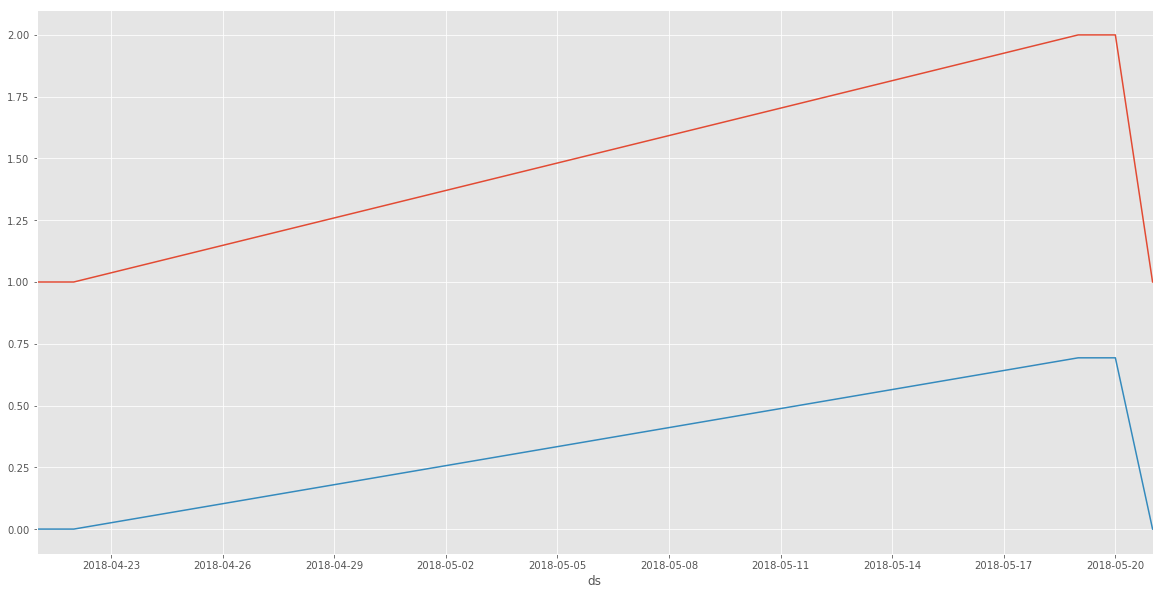

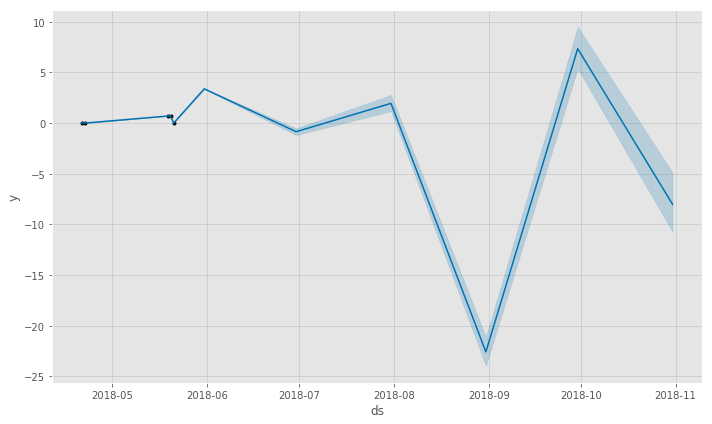

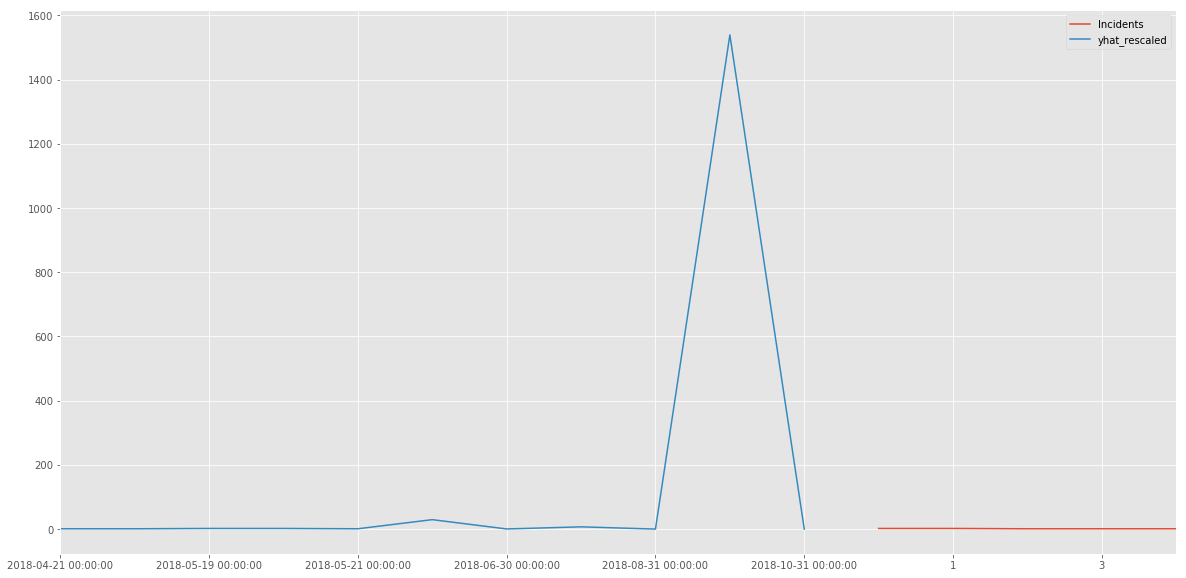

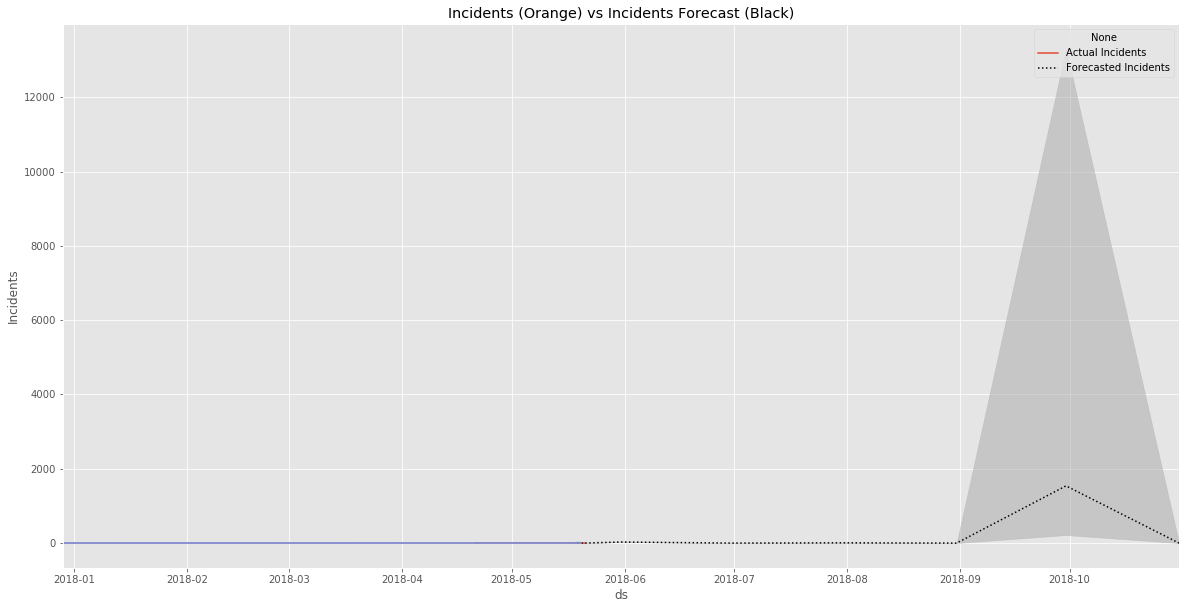

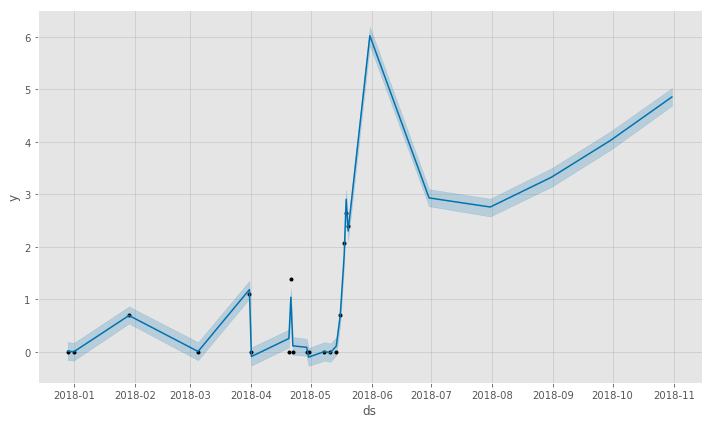

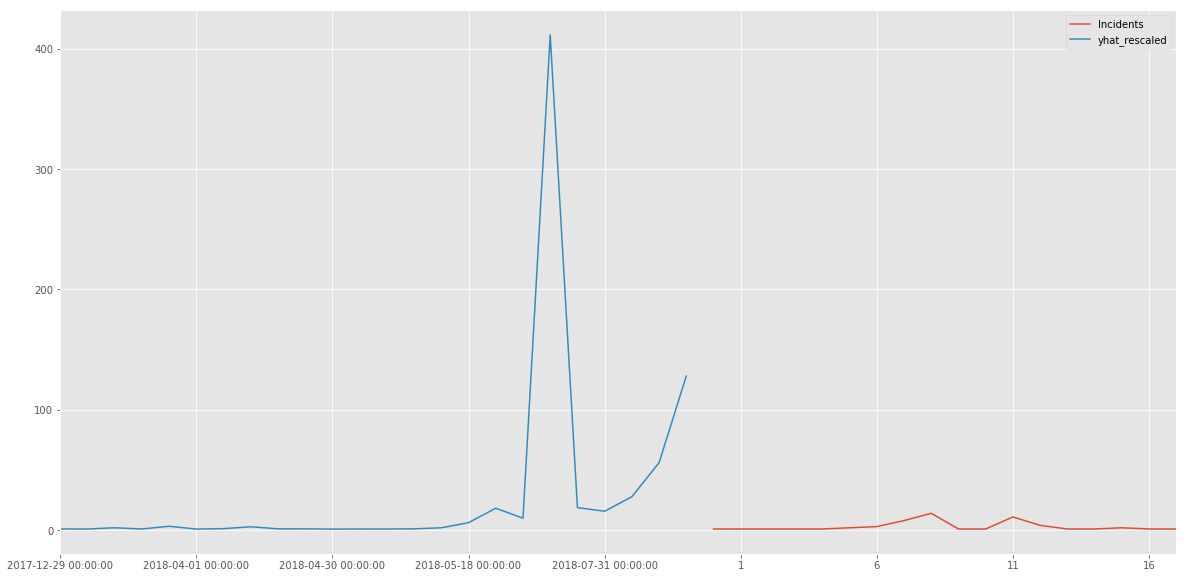

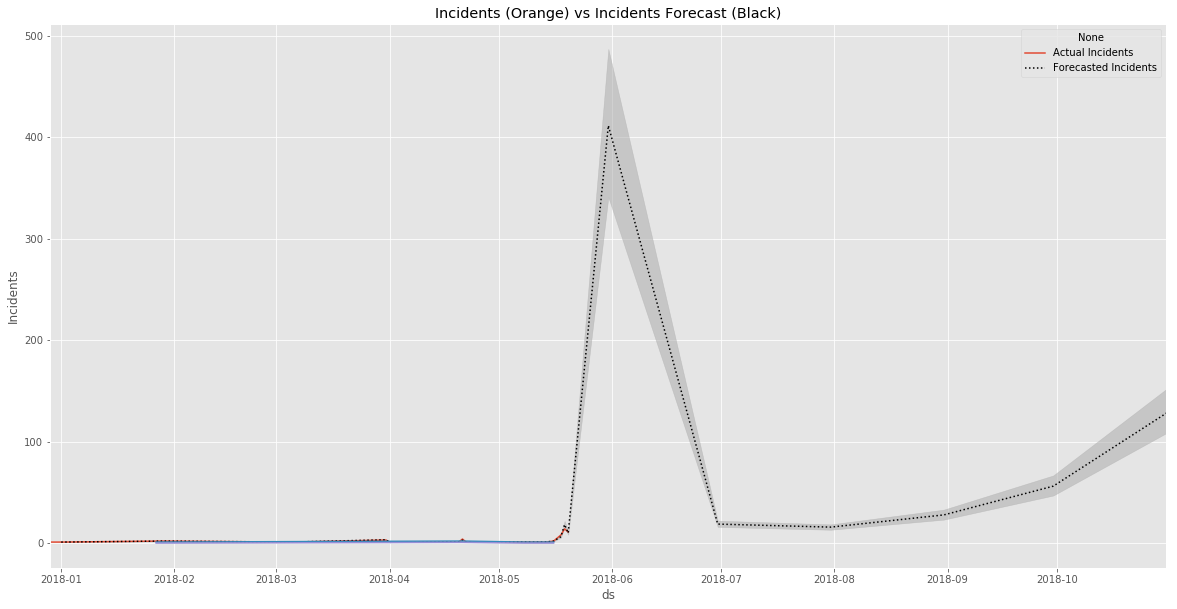

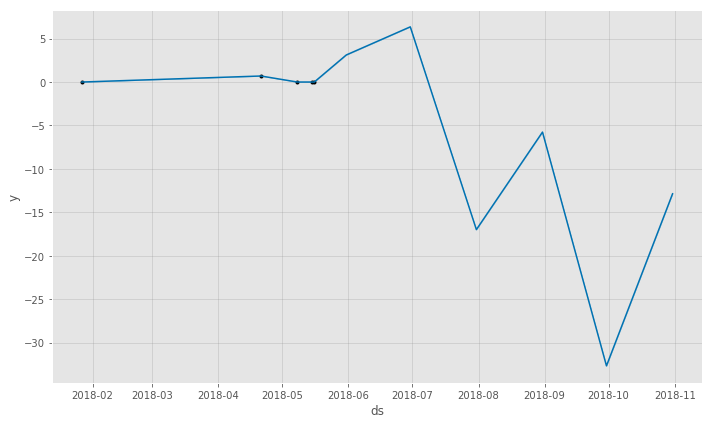

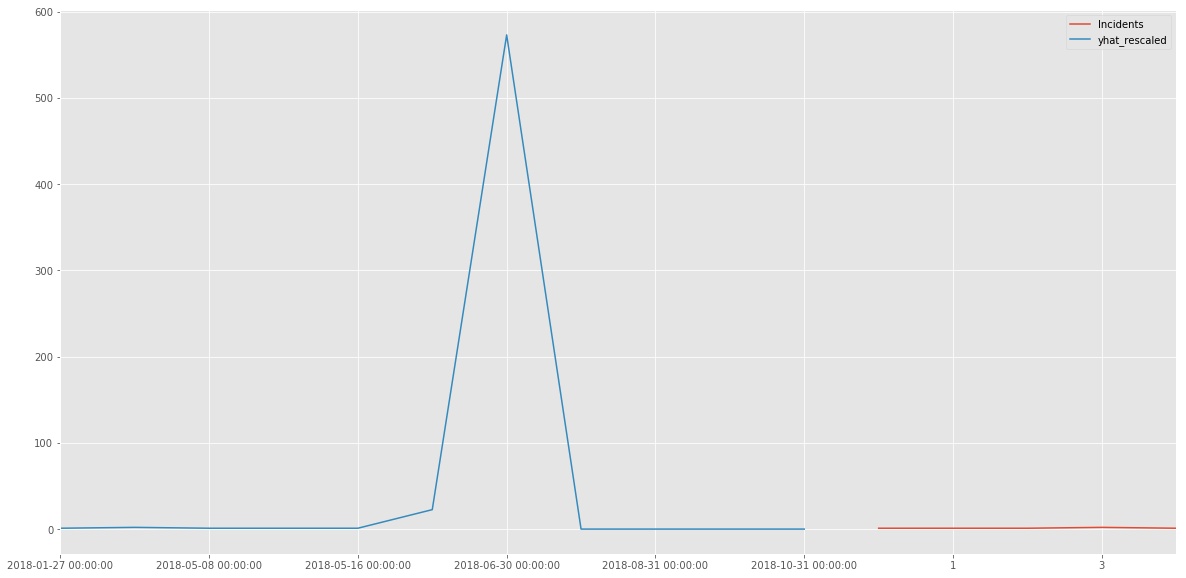

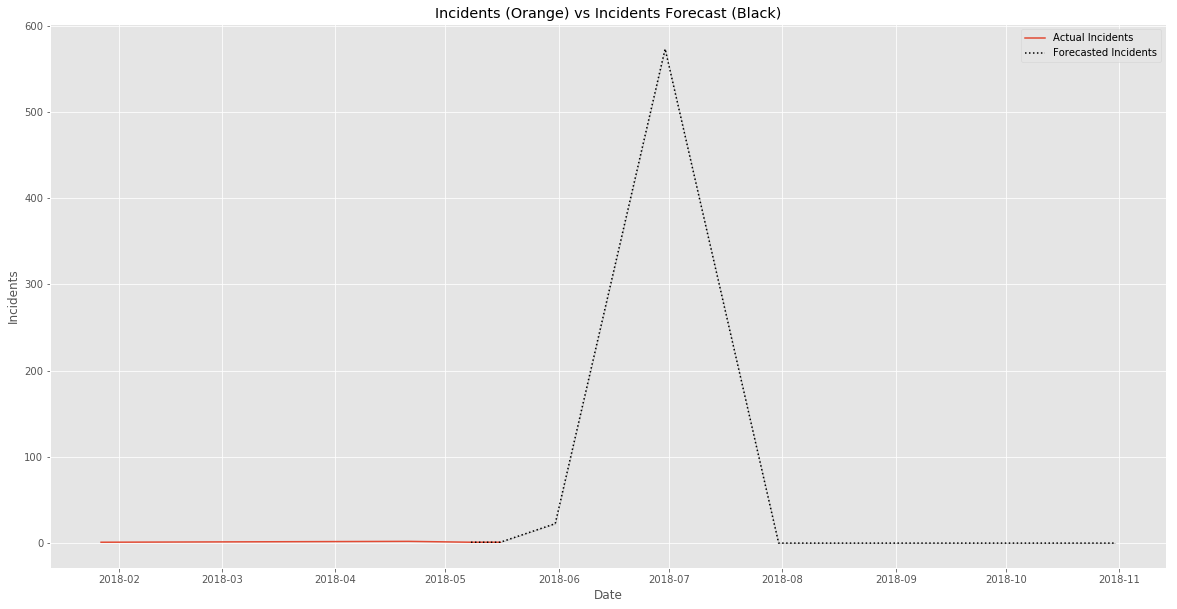

In [9]:
main(store1)